# This file will evaluate the results from `bilby_pipe` in bulk

## Imports

In [1]:
import numpy as np
import pandas as pd
import bilby
import os
import bilby.gw.result as bilby_result
import ast
import matplotlib.pyplot as plt
import ligo.skymap.plot.pp as ppplot

plt.rcParams.update({

    # --- Figure Layout ---
    "figure.figsize": (6, 4),           # Default figure size in inches
    "figure.dpi": 150,                  # DPI for crisp rendering
    "savefig.dpi": 300,                 # Higher DPI for saved figures
    "figure.autolayout": True,          # Avoids label overlap

    # --- Font & Text ---
    "font.family": "monospace",             # Or "sans-serif" for modern look
    "font.serif": ["Terminal"],  # Matches many journals
    "font.size": 10,                    # Base font size
    "axes.titlesize": 14,               # Title font size
    "axes.labelsize": 10,               # Axis label size
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "mathtext.fontset": "dejavuserif",  # Matches the serif font

    # --- Line & Marker Styles ---
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.7,

    # --- Axes ---
    "axes.linewidth": 1.0,              # Frame thickness
    "axes.labelpad": 6,                 # Padding between label and axis
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.spines.top": False,           # Removes top spine
    "axes.spines.right": False,         # Removes right spine

    # --- Ticks ---
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.top": False,
    "ytick.right": False,

    # --- Legend ---
    "legend.frameon": False,
    "legend.handlelength": 2,
    "legend.handletextpad": 0.4,
    "legend.loc": "best",

    # --- Colors and Colormaps ---
    "image.cmap": "viridis",            # Good perceptually uniform default
    "axes.prop_cycle": plt.cycler("color", [
        "#1f77b4", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]),
})

/opt/desc/py/lib/python3.12/site-packages/igwn_ligolw/lsctables.py:57: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## Function definitions

In [2]:
def getMeaningfulColumns(differenceDF):
    cols=[]
    for col in differenceDF:
        if differenceDF[col].isna().all():
            continue
        else:
            cols.append(col)
    return cols

def makePostInjDiffPlot(columns,differenceDF,event=False):
    nrows = int(np.ceil((len(columns))/5))
    fig,axs = plt.subplots(nrows,5,figsize=[10,2*nrows])
    if type(event)==str:
        fig.suptitle(f"{event} - Injection value for ensemble")
    else:
        fig.suptitle(f"Posterior samples - Injection for different parameters of event\n{event.label}")
    for col,ax in zip(columns,axs.flatten()):
        ax.hist(differenceDF[col],histtype='step')
        # ax.grid()
        ax.set_xlabel(col)
        ax.axvline(0,0,ax.get_ylim()[1],color='red')
        # if not (type(event)==str):
        #     ax.set_title(f"True: {}")
    for ax in axs[:,0]:
        ax.set_ylabel("Counts / bin")
    fig.tight_layout(pad=2)
    return fig,axs

def getResult(path,injectionDir="injectionFiles",injectionSuffix="_injection.dat",verbose=False):
    """
    A function to read a path where the bilby_pipe run
    is stored, and return a complete CBCResult object
    """
    parentPath = "/".join(path.split("/")[:-1])
    label = path.split("/")[-1] # The label, taking the form UniformParent,uWeight_aligned_BBH_5
    # Return the final result
    readPath = os.path.join(parentPath,label,"final_result",label+"_data0_0_analysis_H1L1V1_result.hdf5")
    if verbose:
        print(f"ReadPath: {readPath}")
    return bilby_result.CBCResult.from_hdf5(readPath)

def getEventsFromPath(path):
    """
    A function to read all CBC events from a parent catalog directory
    """
    print(f"Reading events from {path}")
    allEvents = []
    eventDirectories = os.listdir(path)
    for event in list(eventDirectories):
        try:
            allEvents.append(getResult(os.path.join(path,event)))
        except:
            print(f"Could not open {event}")
            continue
    return allEvents

In [3]:
testingPath = "/pscratch/sd/s/seanmacb/proj411ProdRuns/testing/"

In [4]:
msk = [(x.lower().startswith("testing")) and (not x.__contains__("testing_2")) for x in os.listdir(testingPath)]
testing_directories = np.sort(np.array(os.listdir(testingPath))[np.array(msk)])

In [5]:
testing_directories

array(['testing_0', 'testing_1', 'testing_3', 'testing_4'], dtype='<U20')

Reading from directory testing_0
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/testing/testing_0
Could not open allInis.txt


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open testRun.sh


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open iniFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open injectionFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open allInjs.txt


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Number of events for testing_0: 50


16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : mass_ratio: 0.020439928479525804
16:43 bilby INFO    : chirp_mass: 9.326479784257785e-24
16:43 bilby INFO    : luminosity_distance: 4.402197643344646e-15
16:43 bilby INFO    : dec: 0.15966916714777524
16:43 bilby INFO    : ra: 0.16648536026400185
16:43 bilby INFO    : a_1: 0.5966761804483344
16:43 bilby INFO    : a_2: 0.4760632628189235
16:43 bilby INFO    : psi: 0.9321629192288319
16:43 bilby INFO    : phase: 0.5835860071120899
16:43 bilby INFO    : theta_jn: 0.0029169989793539353
16:43 bilby INFO    : phi_12: 2.889177863175598e-12
16:43 bilby INFO    : phi_jl: 8.865429634335762e-13
16:43 bilby INFO    : tilt_1: 3.4729419081580435e-13
16:43 bilby INFO    : tilt_2: 4.392853499119748e-12
16:43 bilby INFO    : geocent_time: 0.0012799218548020797
16:43 bilby INFO    : Combined p-value: 3.1913904413437434e-73
16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : luminosity_distance: 4.402197643344646e-15
16:43 bilb

Reading from directory testing_1
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/testing/testing_1
Could not open allInis.txt


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open testRun.sh


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open iniFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open injectionFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Number of events for testing_1: 50


16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : mass_ratio: 0.481256006446771
16:43 bilby INFO    : chirp_mass: 1.8733742310952523e-16
16:43 bilby INFO    : luminosity_distance: 9.657931153196242e-08
16:43 bilby INFO    : dec: 0.04871014636360482
16:43 bilby INFO    : ra: 0.5915387941228116
16:43 bilby INFO    : a_1: 0.2886829393167075
16:43 bilby INFO    : a_2: 0.4944284424279588
16:43 bilby INFO    : psi: 0.6310639817995941
16:43 bilby INFO    : phase: 0.31840175488051337
16:43 bilby INFO    : theta_jn: 0.0012523749634483217
16:43 bilby INFO    : phi_12: 4.405451055671056e-25
16:43 bilby INFO    : phi_jl: 4.405451055671056e-25
16:43 bilby INFO    : tilt_1: 2.7556432376784104e-26
16:43 bilby INFO    : tilt_2: 4.405451055671056e-25
16:43 bilby INFO    : geocent_time: 0.06849059230560284
16:43 bilby INFO    : Combined p-value: 7.1571010611889015e-106
16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : luminosity_distance: 9.657931153196242e-08
16:43 bilby I

Reading from directory testing_3
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/testing/testing_3


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open allInis.txt


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_45


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_5


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open testRun.sh


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open iniFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open injectionFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Number of events for testing_3: 48


16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : mass_ratio: 0.023598266453270123
16:43 bilby INFO    : chirp_mass: 0.8514403090179912
16:43 bilby INFO    : luminosity_distance: 0.7935801091474264
16:43 bilby INFO    : dec: 0.9223385213494973
16:43 bilby INFO    : ra: 0.47909337353659764
16:43 bilby INFO    : chi_1: nan
16:43 bilby INFO    : chi_2: nan
16:43 bilby INFO    : psi: 0.8367580138029703
16:43 bilby INFO    : phase: 0.5440352136387641
16:43 bilby INFO    : theta_jn: 0.5246965984070489
16:43 bilby INFO    : geocent_time: 0.2173240003292487
16:43 bilby INFO    : Combined p-value: nan
16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : luminosity_distance: 0.7935801091474264
16:43 bilby INFO    : chirp_mass: 0.8514403090179912
16:43 bilby INFO    : ra: 0.47909337353659764
16:43 bilby INFO    : dec: 0.9223385213494973
16:43 bilby INFO    : mass_ratio: 0.023598266453270123
16:43 bilby INFO    : Combined p-value: 0.4483693963575277
16:43 bilby INFO    :

Reading from directory testing_4
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/testing/testing_4
Could not open UniformParent,uWeight_aligned_BBH_20
Could not open allInis.txt


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_16
Could not open UniformParent,uWeight_aligned_BBH_1


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_precessing_BBH_11


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_precessing_BBH_16
Could not open UniformParent,uWeight_precessing_BBH_14
Could not open UniformParent,uWeight_aligned_BBH_21


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_24
Could not open UniformParent,uWeight_aligned_BBH_27
Could not open UniformParent,uWeight_precessing_BBH_8
Could not open UniformParent,uWeight_precessing_BBH_6
Could not open UniformParent,uWeight_aligned_BBH_11
Could not open testRun.sh
Could not open UniformParent,uWeight_aligned_BBH_18


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_0_A
Could not open UniformParent,uWeight_aligned_BBH_6


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open iniFiles
Could not open UniformParent,uWeight_precessing_BBH_15


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_12


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open UniformParent,uWeight_aligned_BBH_7
Could not open UniformParent,uWeight_precessing_BBH_21
Could not open UniformParent,uWeight_precessing_BBH_10
Could not open injectionFiles


16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
16:43 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open iniSub.log
Number of events for testing_4: 31


16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : mass_ratio: 0.9750733116599748
16:43 bilby INFO    : chirp_mass: 0.11060441269679555
16:43 bilby INFO    : luminosity_distance: 0.3759989284219387
16:43 bilby INFO    : dec: 0.9479389362431616
16:43 bilby INFO    : ra: 0.7086467473159938
16:43 bilby INFO    : chi_1: nan
16:43 bilby INFO    : chi_2: nan
16:43 bilby INFO    : psi: 0.5591472397395116
16:43 bilby INFO    : phase: 0.6064217942215004
16:43 bilby INFO    : theta_jn: 0.47974935457362566
16:43 bilby INFO    : geocent_time: 0.08581629778192523
16:43 bilby INFO    : Combined p-value: nan
16:43 bilby INFO    : Key: KS-test p-value
16:43 bilby INFO    : luminosity_distance: 0.3759989284219387
16:43 bilby INFO    : chirp_mass: 0.11060441269679555
16:43 bilby INFO    : ra: 0.7086467473159938
16:43 bilby INFO    : dec: 0.9479389362431616
16:43 bilby INFO    : mass_ratio: 0.9750733116599748
16:43 bilby INFO    : Combined p-value: 0.7058512575750683


CPU times: user 24.2 s, sys: 1.42 s, total: 25.6 s
Wall time: 25.8 s


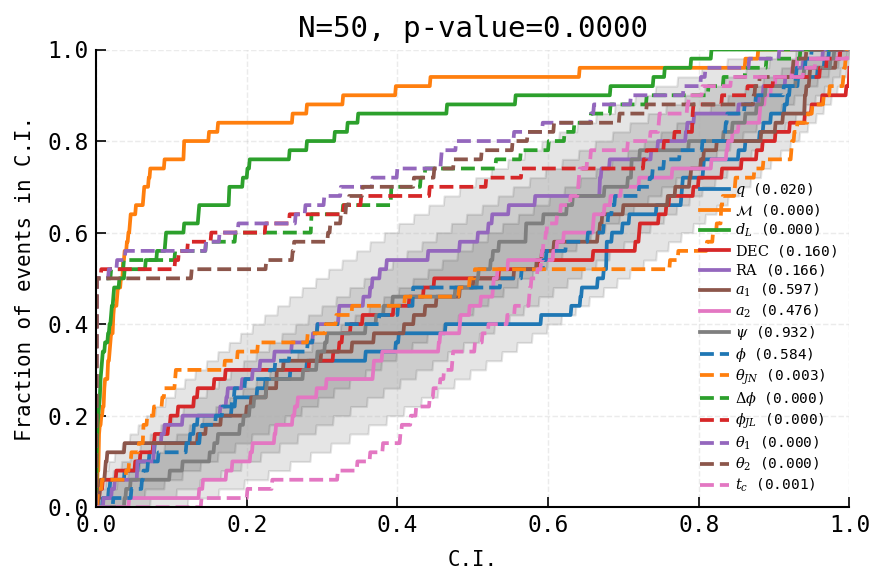

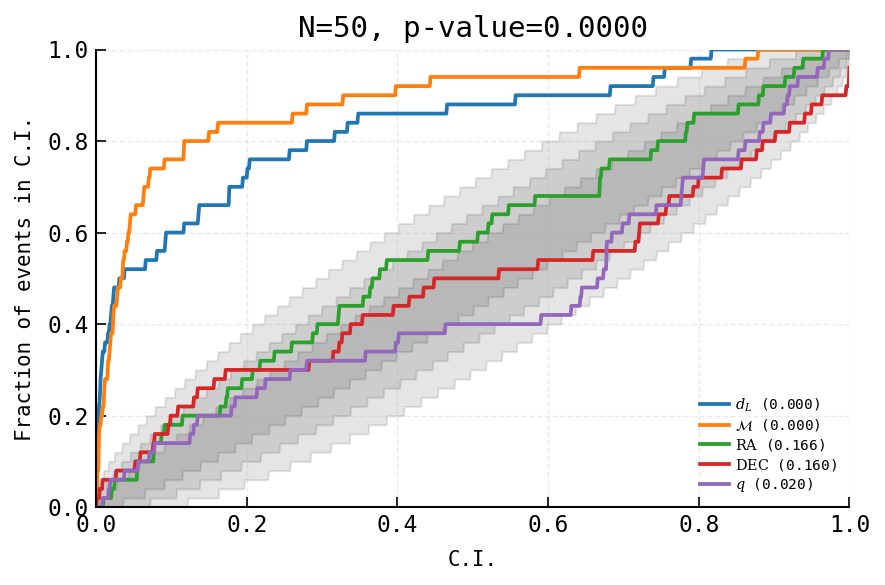

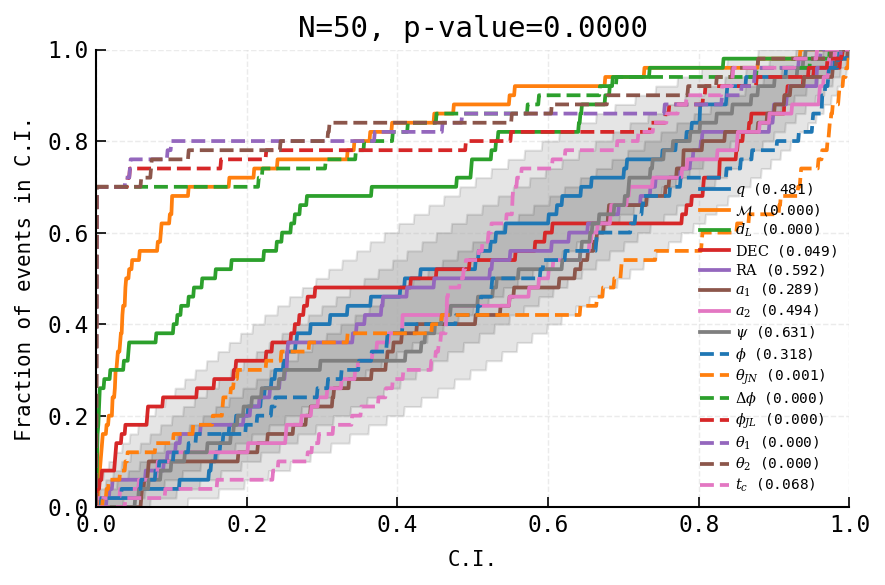

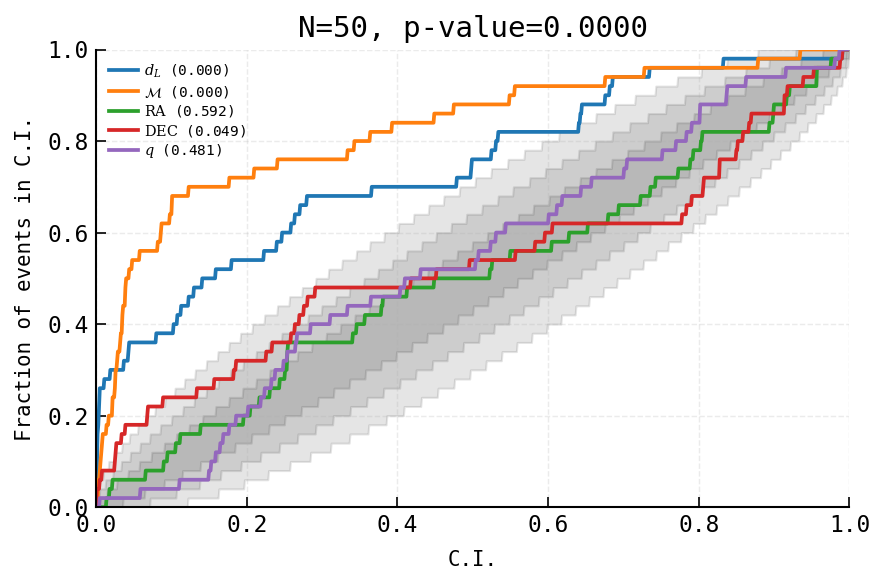

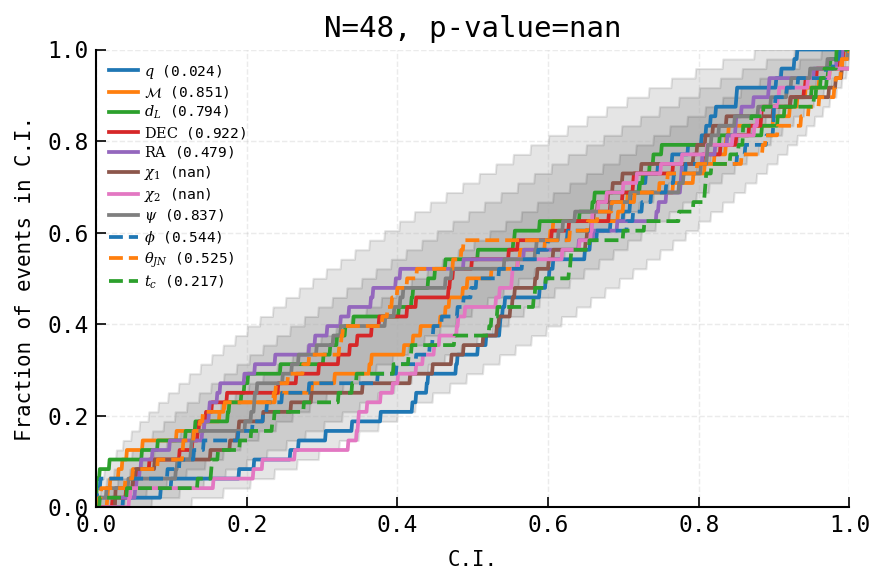

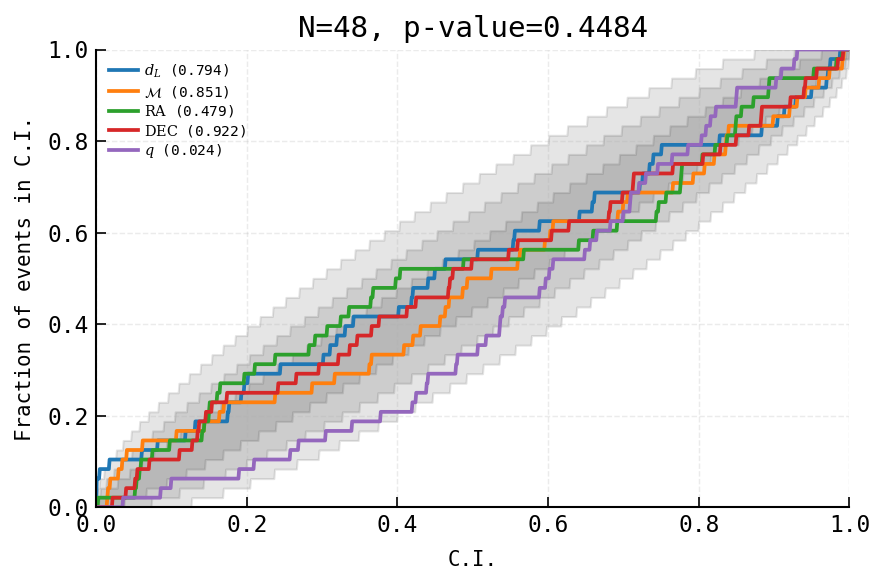

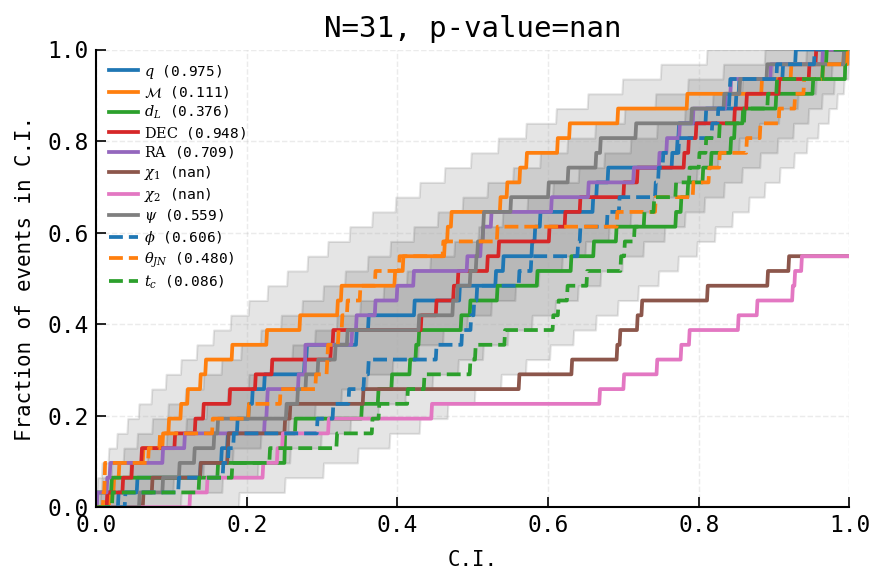

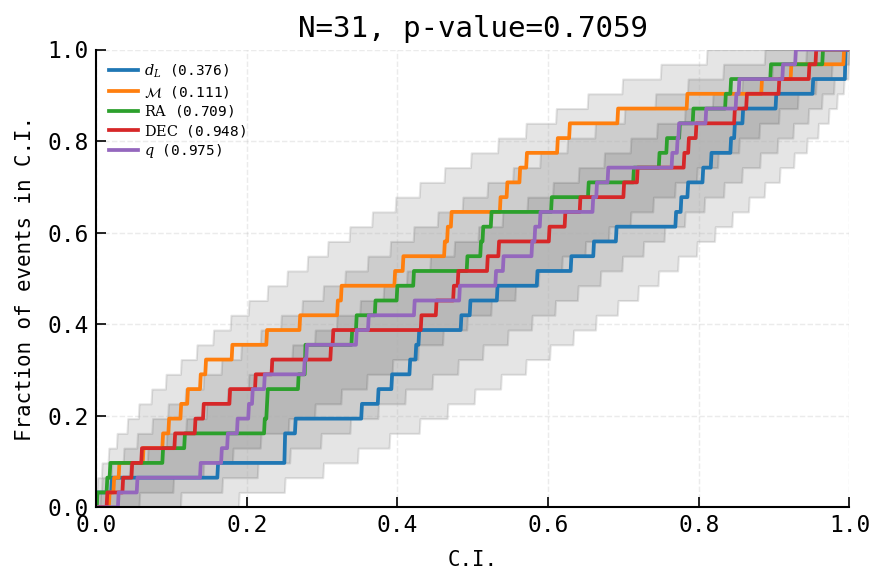

In [6]:
%%time 
for t in testing_directories:
    t_directory = os.path.join(testingPath,t)
    print(f"Reading from directory {t}")
    allEvents = getEventsFromPath(t_directory)
    print(f"Number of events for {t}: {len(allEvents)}")
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}.png",)
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}_inset.png",keys=["luminosity_distance","chirp_mass","ra","dec","mass_ratio"])

## Now, run the same validation test for the catalogs

In [7]:
catalogPath = "/pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/"

In [8]:
msk = [(x.__contains__("UniformParent")) for x in os.listdir(catalogPath)]
catalog_directories = np.sort(np.array(os.listdir(catalogPath))[np.array(msk)])

In [9]:
catalog_directories

array([], dtype='<U20')

In [ ]:
%%time 
for t in catalog_directories:
    t_directory = os.path.join(catalogPath,t)
    print(f"Reading from directory {t}")
    allEvents = getEventsFromPath(t_directory)
    print(f"Number of events for {t}: {len(allEvents)}")
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}.png",)
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}_inset.png",keys=["luminosity_distance","chirp_mass","ra","dec","mass_ratio"])